In [1]:
#stewart et al. data preprocessing
import os
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import anndata as ad
import scanpy as sc
import os
import pandas as pd
import numpy as np
import useful_functions as uf
import scvi
sc.set_figure_params(figsize=(6, 6))
import sys
print(sys.executable)

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0


/home/jovyan/my-conda-envs/myenv/bin/python


/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(pd.__version__)
print(scvi.__version__)
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')


1.9.1
0.8.0
1.5.1
0.19.0


In [3]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/10X_data/science_paper_data')

In [4]:
file_paths = np.array(pd.read_csv("channels_use.txt", header = None)[0])

In [5]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/10X_data/science_paper_data')
adata_list = {}
p=0
for i in file_paths:
    print(i)
    path = i
    try:        
        #read filtered
        #print('reading filtered')
        fname = os.path.join(path, 'scAR_denoised.h5ad')
        adata_in = sc.read_h5ad(fname)
        adata_in.var_names_make_unique()
        #pop this into the list we are building
        adata_list[p] = adata_in
        p=p+1
    except FileNotFoundError:
        print("channel didn't run")
    pass 


cellranger700_count_22288_4602STDY6795897_GRCh38-2020-A
cellranger700_count_22288_4602STDY6795898_GRCh38-2020-A
cellranger700_count_22843_4602STDY6930852_GRCh38-2020-A
cellranger700_count_22843_4602STDY6930853_GRCh38-2020-A
cellranger700_count_22843_4602STDY6930856_GRCh38-2020-A
cellranger700_count_22862_4602STDY6949178_GRCh38-2020-A
cellranger700_count_22862_4602STDY6949179_GRCh38-2020-A
cellranger700_count_22862_4602STDY6949180_GRCh38-2020-A
cellranger700_count_22862_4602STDY6949181_GRCh38-2020-A
cellranger700_count_22862_4602STDY6949184_GRCh38-2020-A
cellranger700_count_22862_4602STDY6949185_GRCh38-2020-A
cellranger700_count_22863_4602STDY6949186_GRCh38-2020-A
cellranger700_count_22863_4602STDY6949187_GRCh38-2020-A
cellranger700_count_22863_4602STDY6949188_GRCh38-2020-A
cellranger700_count_22863_4602STDY6949189_GRCh38-2020-A
cellranger700_count_22936_4602STDY6949192_GRCh38-2020-A
cellranger700_count_22936_4602STDY6949195_GRCh38-2020-A
cellranger700_count_23141_4602STDY6976426_GRCh38

In [6]:
#concatenate these individual datasets.
adata = sc.concat(adata_list)
adata.var = adata_list[0].var
adata.var['Symbol'] = adata.var_names.values
adata.var['ID'] = adata.var['gene_ids']
#sort out obs names
#first we split the paths according to "_" and assign this to channel
splits = []
for i in adata.obs['path']:
    splits.append(str(i).split("_")[3])
#get channels  
adata.obs['channel'] = np.array(splits)
#set the original barcodes so we can map celltypes
adata.obs['orig_barcodes'] = np.array(adata.obs['channel']) + "_" + np.array(adata.obs['barcode'])

In [7]:
#import the original data which has our initial annotation labels.
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/public_data/stewart_2019')
adata_orig = sc.read_h5ad("./science_paper_mature_kidney.h5ad")
common_barcodes = np.intersect1d(np.array(adata_orig.obs_names),
                                    adata.obs['orig_barcodes'] )

In [8]:
#subset the adata and map the barcodes/celltypes
adata = adata[adata.obs['orig_barcodes'].isin(common_barcodes)]
adata.obs['annotated_celltype'] = np.array(adata_orig.obs['celltype'][common_barcodes])
adata.obs['donor'] = np.array(adata_orig.obs['Experiment'][common_barcodes])

In [9]:
#set X to denoised
from scipy import sparse
adata.X = adata.layers['denoised_counts'] =  sparse.csr_matrix(adata.layers['denoised_counts'])

In [10]:
#now we subset on the basis of QC metrics
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=[10,20,50], log1p=True, inplace=True)

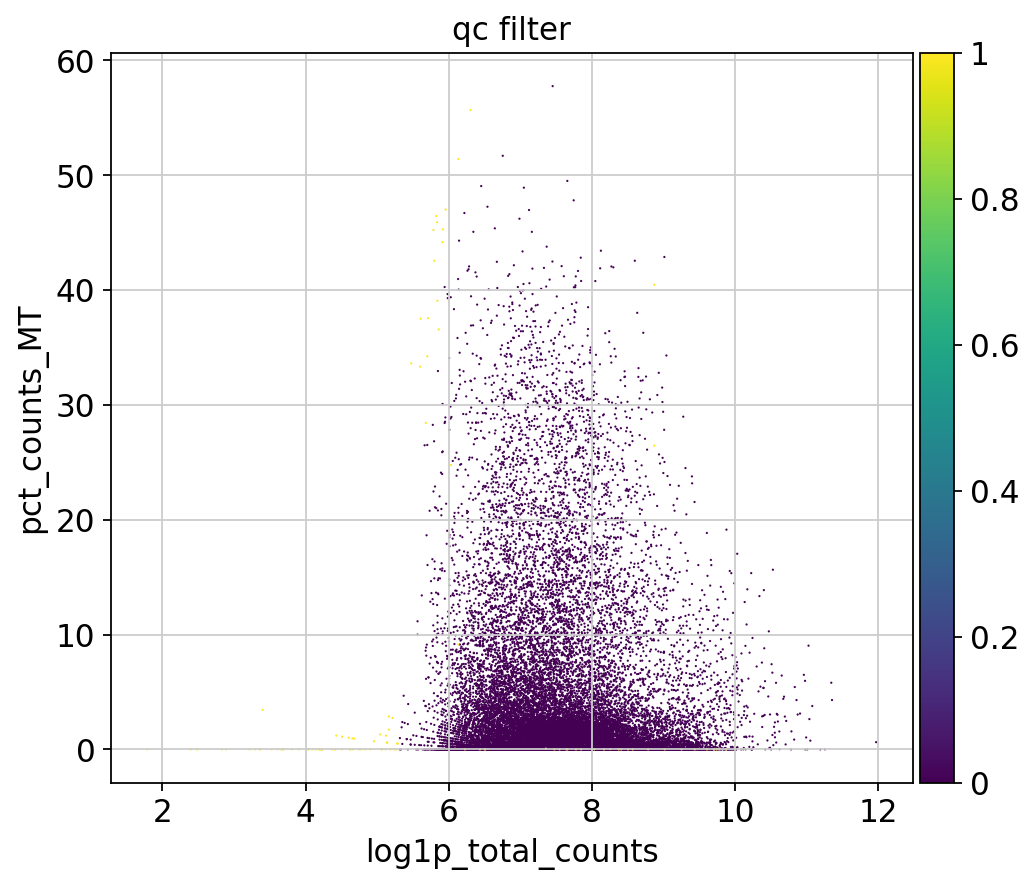

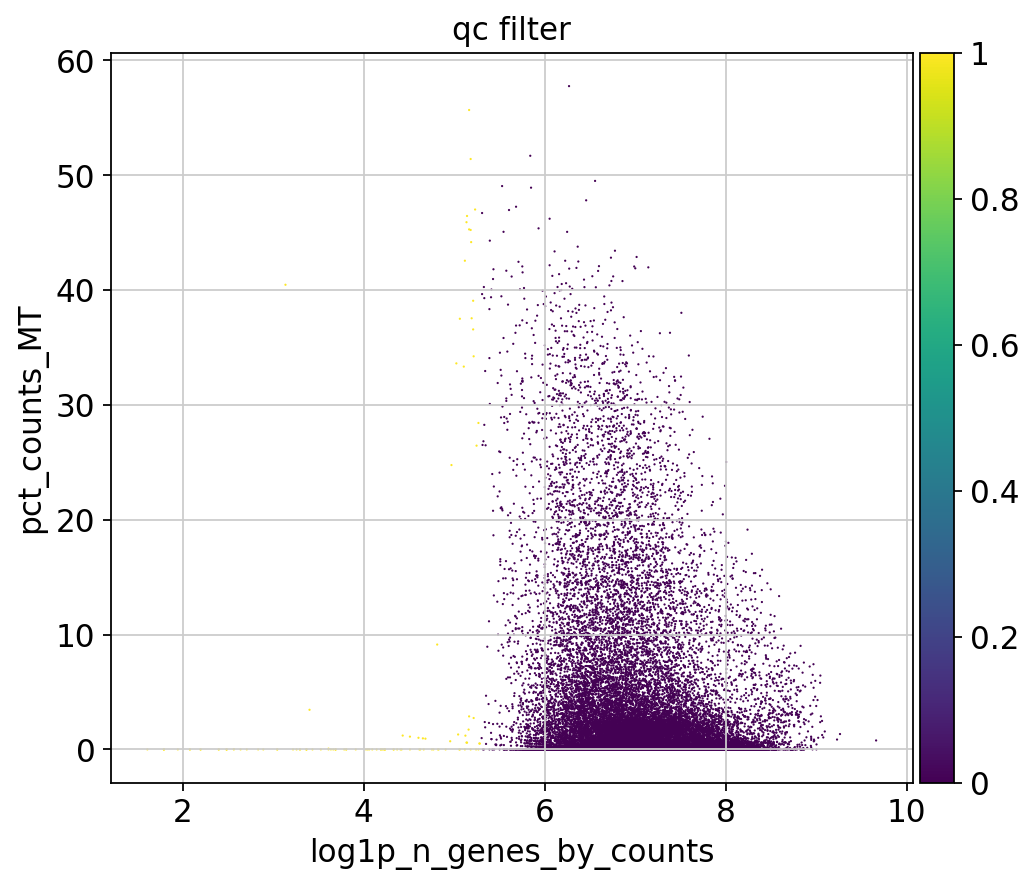

In [11]:
#make a QC filter and plot
from functools import reduce
ngene_filter = adata.obs_names.values[adata.obs['n_genes_by_counts'] < 200]
mt_filter = adata.obs_names.values[adata.obs['pct_counts_MT'] > 60]                                   
adata.obs['qc_filter'] = adata.obs_names.isin(np.unique(np.concatenate([ngene_filter,  mt_filter])))
sc.pl.scatter(adata, x='log1p_total_counts', y='pct_counts_MT', color = 'qc_filter')
sc.pl.scatter(adata, x='log1p_n_genes_by_counts', y='pct_counts_MT', color = 'qc_filter')

In [12]:
#filter the barcodes
adata = adata[~adata.obs['qc_filter']]

In [13]:
#save this as raw adata
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data')
adata.write_h5ad("./public_data/stewart_2019/stewart_remap_raw.h5ad")